In [ ]:
import warnings
warnings.simplefilter(action='ignore')

In [ ]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
%matplotlib inline

import yaml
from nnaps import predictors

Using TensorFlow backend.


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('../data/raw/sdBShortP_large_BPS_set.csv')

In [ ]:
df.info(verbose=True
       )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13175 entries, 0 to 13174
Data columns (total 108 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   path                     object 
 1   stability                object 
 2   n_ML_phases              int64  
 3   FeH_init                 float64
 4   Z_init                   float64
 5   termination_code         object 
 6   PRLODays                 float64
 7   PoverPMax                int64  
 8   TtipMyr                  float64
 9   GalAgeMyr                float64
 10  AgeBinNum                int64  
 11  DeltaTBin                int64  
 12  P_init                   float64
 13  P_final                  float64
 14  M1_init                  float64
 15  M1_final                 float64
 16  M2_init                  float64
 17  M2_final                 float64
 18  q_init                   float64
 19  q_final                  float64
 20  M1_HeIgnition            float64
 21  M1core_HeIg

In [ ]:
# extract the alpha value from the ce_parameters (alpha_ce is always the same as alpha_th)
df['alpha_ce'] = df['ce_parameters'].apply(lambda x: eval(x)['a_ce'])

In [ ]:
# Mark systems with a He ignition or burning error as error. ignore other errors.
df['error'] = df['error_flags'].apply(lambda x: 1 if 4 in eval(x) or 5 in eval(x) else 0)

In [ ]:
# remove systems that merge or are contact systems (the latter are likely also mergers)
df = df[(df['stability'] != 'merger') & (df['stability'] != 'contact')]

In [ ]:
df['product'] = 'UK'

for i, line in df.iterrows():
    
    sdA = line['sdA']
    sdB = line['sdB']
    sdO = line['sdO']
    HeBurn = line['HeCoreBurning']
    HeWD = line['He-WD']
    
    product = 'failed'
    if line['stability'] == 'CE' or line['stability'] == 'merger' or line['stability'] == 'contact':
        product = 'UK'
    elif sdA:
        product = 'sdA'
    elif sdB:
        product = 'sdB'
    elif sdO:
        product = 'sdO'
    elif HeWD:
        product = 'He-WD'
    elif HeBurn:
        product = 'HB'
    
    df.loc[i, 'product'] = product

In [ ]:
df['stability'].value_counts()

stable    6387
CE        3276
Name: stability, dtype: int64

In [ ]:
df_ce =df[df['stability'] == 'CE']
df_stable = df[(df['stability'] == 'stable') & (df['error'] == 0)]
df_he = df_stable[df_stable['HeCoreBurning'] == 1]

Remove the CE systems that ignite He before the CE and ML phase

In [ ]:
df_ce['HeCoreBurning'].value_counts()

False    2864
True      412
Name: HeCoreBurning, dtype: int64

In [ ]:
df_ce = df_ce[~df_ce['HeCoreBurning']]

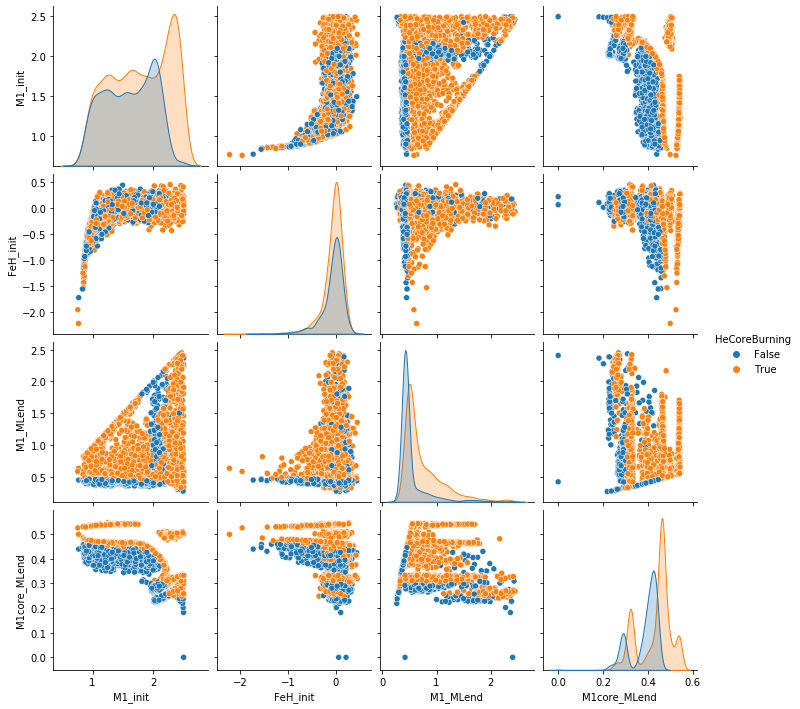

In [ ]:
sns.pairplot(df_stable, vars=['M1_init', 'FeH_init', 'M1_MLend', 'M1core_MLend'], hue='HeCoreBurning')

## core and envelope mass during He core burning

In [ ]:
df_he['core_growth'] = df_he['M1core_HeCoreBurning'] - df_he['M1core_MLend']

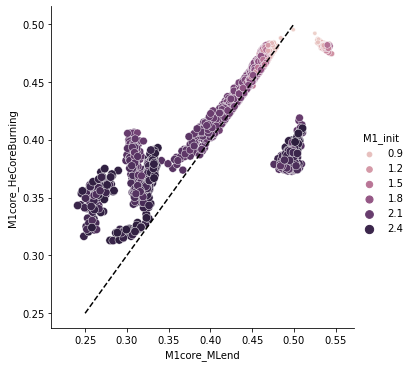

In [ ]:
sns.relplot('M1core_MLend', 'M1core_HeCoreBurning', data=df_he, hue='M1_init', size='M1_init')
pl.plot([0.25, 0.5], [0.25, 0.5], '--k')

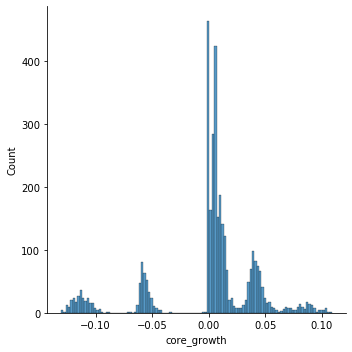

In [ ]:
sns.displot(df_he['core_growth'])

In [ ]:
df_he['core_change'] = pd.cut(df_he['core_growth'], [-0.15, -0.075, -0.01, 0.025, 0.15],
                              labels=['-0.12', '-0.6', '0.02', '0.04'])

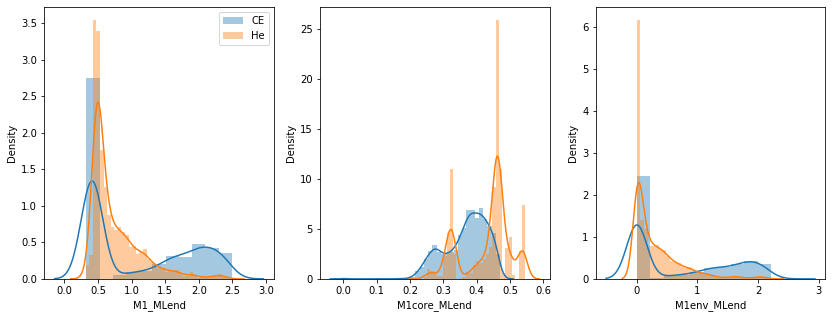

In [ ]:
pl.figure(figsize=(14, 5))
pl.subplot(131)
sns.distplot(df_ce['M1_MLend'], label='CE')
sns.distplot(df_he['M1_MLend'], label='He')
pl.legend()

pl.subplot(132)
sns.distplot(df_ce['M1core_MLend'], label='CE')
sns.distplot(df_he['M1core_MLend'], label='He')

pl.subplot(133)
sns.distplot(df_ce['M1env_MLend'], label='CE')
sns.distplot(df_he['M1env_MLend'], label='He')

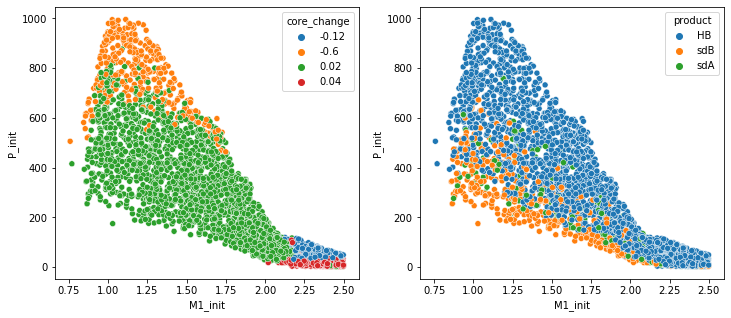

In [ ]:
pl.figure(figsize=(12,5))
ax = pl.subplot(121)
sns.scatterplot('M1_init', 'P_init', data=df_he, hue='core_change', ax=ax)
ax = pl.subplot(122)
sns.scatterplot('M1_init', 'P_init', data=df_he, hue='product', ax=ax)

## Subdwarf vs HB

In [ ]:
df_he['is_sd'] = df_he['product'].apply(lambda x: 0 if x == 'HB' else 1)

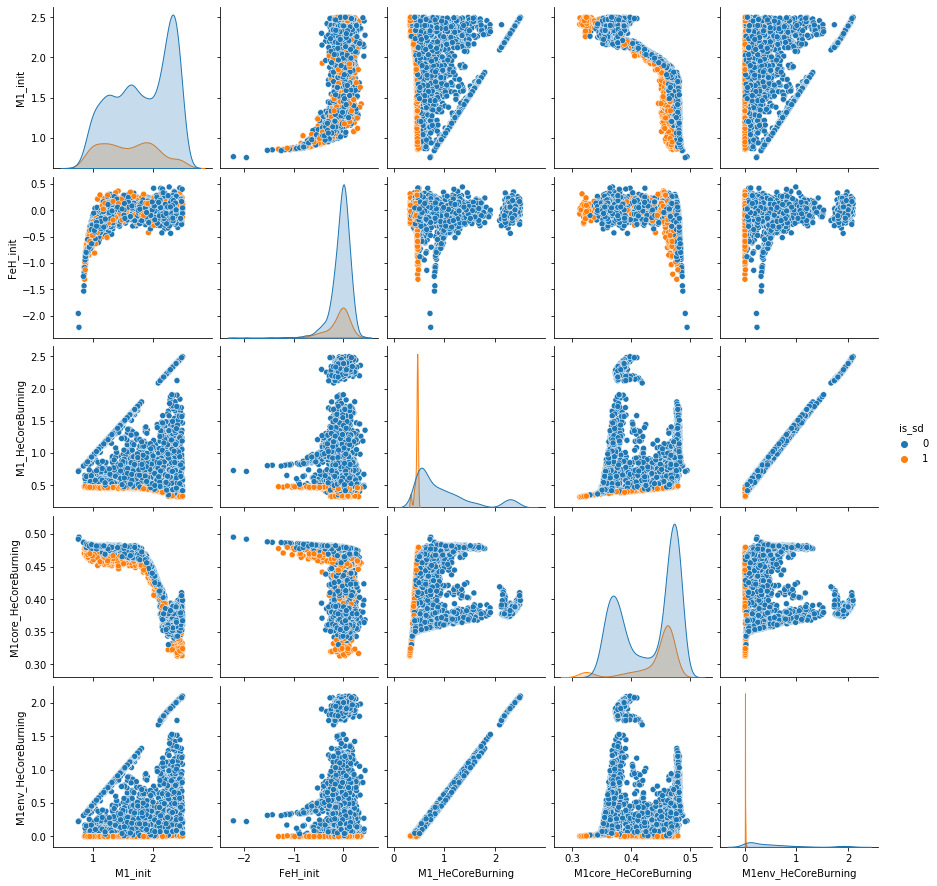

In [ ]:
sns.pairplot(df_he, vars=['M1_init', 'FeH_init', 'M1_HeCoreBurning', 'M1core_HeCoreBurning', 'M1env_HeCoreBurning'], hue='is_sd')

## He core burning properties

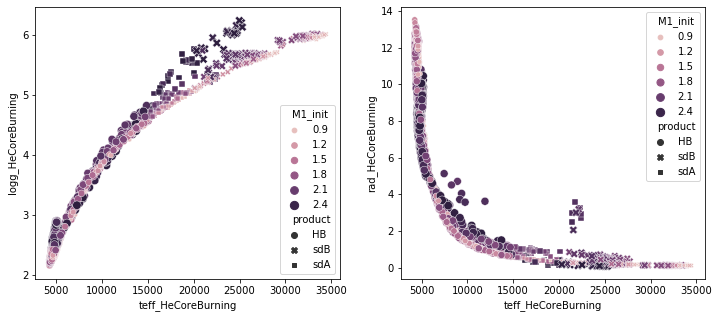

In [ ]:
pl.figure(figsize=(12, 5))

pl.subplot(121)
sns.scatterplot('teff_HeCoreBurning', 'logg_HeCoreBurning', data=df_he, style='product', hue='M1_init', size='M1_init')

pl.subplot(122)
sns.scatterplot('teff_HeCoreBurning', 'rad_HeCoreBurning', data=df_he, style='product', hue='M1_init', size='M1_init')

In [ ]:
df_he[(df_he['product'] == 'sdA') & (df_he['rad_HeCoreBurning'] > 1.5)]

,path,stability,n_ML_phases,FeH_init,Z_init,termination_code,PRLODays,PoverPMax,TtipMyr,GalAgeMyr,AgeBinNum,DeltaTBin,P_init,P_final,M1_init,M1_final,M2_init,M2_final,q_init,q_final,M1_HeIgnition,M1core_HeIgnition,M1env_HeIgnition,age_HeIgnition,duration_HeCoreBurning,logg_HeCoreBurning,teff_HeCoreBurning,rad_HeCoreBurning,M1_HeCoreBurning,M1core_HeCoreBurning,M1env_HeCoreBurning,logg2_HeCoreBurning,teff2_HeCoreBurning,rad2_HeCoreBurning,duration_HeShellBurning,M1_HeShellBurning,M1core_HeShellBurning,M1env_HeShellBurning,M1_MLend,M1core_MLend,M1env_MLend,MS_P,MS_q,MS_M1,MS_M2,MS_age,MS_duration,RGB_P,RGB_q,RGB_M1,RGB_M2,RGB_age,RGB_duration,ML_P,ML_q,ML_M1,ML_M2,ML_Mdot_max,ML_age,ML_duration,CE_P_start,CE_q_start,CE_M1_start,CE_M2_start,CE_P_end,CE_q_end,CE_M1_end,CE_M2_end,CE_age,HeCoreBurning_P,HeCoreBurning_q,HeCoreBurning_M1,HeCoreBurning_M2,HeCoreBurning_age,HeCoreBurning_duration,HeShellBurning_P,HeShellBurning_q,HeShellBurning_M1,HeShellBurning_M2,HeShellBurning_age,HeShellBurning_duration,He-WD_P,He-WD_q,He-WD_M1,He-WD_M2,He-WD_age,CO-WD_P,CO-WD_q,CO-WD_M1,CO-WD_M2,CO-WD_age,MS,RGB,ML,CE,HeCoreBurning,HeShellBurning,sdA,sdB,sdO,He-WD,CO-WD,stability_criterion,stability_limit,ce_profile_name,ce_formalism,ce_parameters,error_flags,alpha_ce,error,product,core_growth,core_change,is_sd
680,M2.232_M1.837_P9.41_Z0.01404_Jz1.000.h5,stable,2,-0.005052,0.014036,accretor_overflow_terminate,9.406904,1,807.874857,475.128181,2,850,9.410006,288.636388,2.232,0.383628,1.837,1.837,1.215024,0.208834,0.383628,0.382305,0.001322,7.051691e+08,2.018058e+08,5.292421,22084.146775,2.995714,0.402788,0.378018,0.024770,4.013232,7780.382774,2.184664,1.500780e+08,0.383628,0.382026,0.001602,0.724023,0.306795,0.417228,9.410053,1.215024,2.231999,1.837,2.162356e+06,6.518214e+08,9.466414,1.214698,2.231400,1.837,6.539837e+08,4.674897e+07,8.194382,1.214653,2.231317,1.837,-5.322660,6.694968e+08,1.164565e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,288.708988,0.208834,0.383628,1.837,7.051691e+08,2.018058e+08,288.708988,0.208834,0.383628,1.837,9.415950e+08,1.500780e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,False,True,True,True,False,False,False,False,Mdot,-0.5,profile_1_mdot-0.5,dewi_tauris2000,"{'a_ce': 0.469, 'a_th': 0.469}",[2],0.469,0,sdA,0.071223,0.04,1
1437,M2.229_M1.440_P15.91_Z0.01364_Jz1.000.h5,stable,2,-0.017503,0.013639,accretor_overflow_terminate,15.914711,1,805.992128,797.751096,2,850,15.910001,269.224053,2.229,0.381716,1.440,1.440,1.547917,0.265081,0.381716,0.380361,0.001355,7.039991e+08,2.263090e+08,5.333189,22351.915489,2.799302,0.399793,0.375897,0.023896,4.228658,7094.189783,1.528189,1.641535e+08,0.381716,0.379614,0.002102,0.722665,0.306954,0.415710,15.910010,1.547916,2.228999,1.440,2.227210e+06,6.503388e+08,16.038066,1.547498,2.228397,1.440,6.525660e+08,4.630894e+07,13.388509,1.547376,2.228222,1.440,-3.070932,6.729063e+08,6.909402e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,269.261966,0.265081,0.381716,1.440,7.039991e+08,2.263090e+08,269.261966,0.265081,0.381716,1.440,9.312324e+08,1.641535e+08,NaN,NaN,NaN,NaN,NaN,269.261935,0.265081,0.381716,1.440,2.212686e+09,True,True,True,False,True,True,True,False,False,False,True,Mdot,-2.5,profile_1_mdot-2.5,dewi_tauris2000,"{'a_ce': 0.582, 'a_th': 0.582}",[2],0.582,0,sdA,0.068943,0.04,1
3742,M2.300_M2.200_P4.92_Z0.01937_Jz1.000.h5,stable,2,0.134771,0.019367,accretor_overflow_terminate,4.921314,1,808.443462,958.670790,2,850,4.920126,240.582389,2.300,0.370951,2.200,2.200,1.045454,0.168614,0.370951,0.369492,0.001459,7.227383e+08,2.559303e+08,5.353198,21443.865622,2.506842,0.382659,0.366521,0.016138,2.975838,5622.016941,9.608620,5.664519e+05,0.370951,0.369482,0.001468,0.599745,0.306238,0.293507,4.921874,1.045454,2.299998,2.200,4.182632e+06,6.722073e+08,4.849070,1.045145,2.299319,2.200,6.763899e+08,4.186423e+07,4.297677,1.045100,2.299219,2.200,-6.089092,6.867697e+08,1.420003e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240.623871,0.168614,0.370951,2.200,7.227383e+08,2.559303e+08,240.623722,0.168614,0.370

# Comparison of post CE with post RLOF properties

In [ ]:
from astropy.stats import histogram
from astropy.visualization import hist

Text(0.5, 1.0, 'Stable')

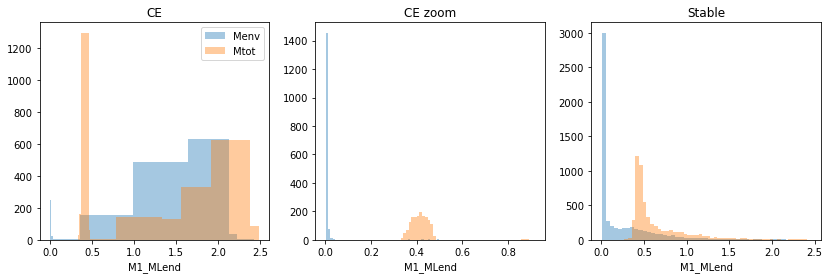

In [ ]:
pl.figure(figsize=(14, 4))

pl.subplot(131)
_, bins = histogram(df_ce['M1env_MLend'], bins='blocks')
sns.distplot(df_ce['M1env_MLend'], kde=False, label='Menv', color='C0', bins=bins)
_, bins = histogram(df_ce['M1_MLend'], bins='blocks')
sns.distplot(df_ce['M1_MLend'], kde=False, label='Mtot', color='C1', bins=bins)

# sns.distplot(df_ce[df_ce['M1env_MLend'] < 0.5]['M1env_MLend'], kde=False, label='Menv', color='C0')
# sns.distplot(df_ce[df_ce['M1env_MLend'] < 0.5]['M1_MLend'], kde=False, label='Mtot', color='C1')

# sns.distplot(df_ce[df_ce['M1env_MLend'] >= 0.5]['M1env_MLend'], kde=False, label='Menv', color='C0')
# sns.distplot(df_ce[df_ce['M1env_MLend'] >= 0.5]['M1_MLend'], kde=False, label='Mtot', color='C1')
pl.title('CE')
pl.legend()

pl.subplot(132)
sns.distplot(df_ce[df_ce['M1env_MLend'] < 0.5]['M1env_MLend'], kde=False, label='Menv', color='C0')
sns.distplot(df_ce[df_ce['M1env_MLend'] < 0.5]['M1_MLend'], kde=False, label='Mtot', color='C1')

pl.title('CE zoom')

pl.subplot(133)
sns.distplot(df_stable['M1env_MLend'], kde=False)
sns.distplot(df_stable['M1_MLend'], kde=False)
pl.title('Stable')

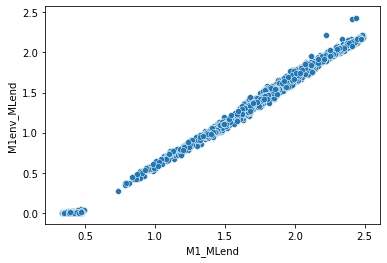

In [ ]:
sns.scatterplot('M1_MLend', 'M1env_MLend', data=df_ce)

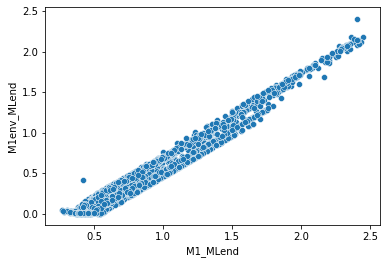

In [ ]:
sns.scatterplot('M1_MLend', 'M1env_MLend', data=df_stable)